<a href="https://colab.research.google.com/github/4chuanMcChicken/portfolio/blob/master/DpNovo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from keras import backend as K
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing import image

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Conv1D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
from tensorflow.keras import layers
from keras.losses import categorical_crossentropy
from keras.models import load_model
import math

import torch.nn.functional as torch_F
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import xml.etree.ElementTree as ET

In [ ]:
mass_map = {
        'A': 71.03711, # 0
        'R': 156.10111, # 1
        'N': 114.04293, # 2
        'D': 115.02694, # 3
        'C': 103.00919, # 4
        'E': 129.04259, # 5
        'Q': 128.05858, # 6
        'G': 57.02146, # 7
        'H': 137.05891, # 8
        'I': 113.08406, # 9
        'L': 113.08406, # 10
        'K': 128.09496, # 11
        'M': 131.04049, # 12
        'F': 147.06841, # 13
        'P': 97.05276, # 14
        'S': 87.03203, # 15
        'T': 101.04768, # 16
        'W': 186.07931, # 17
        'Y': 163.06333, # 18
        'V': 99.06841, # 19
        'M*': 147.0353, # 20
        'C*': 160.0306, # 21
        'A*': 42.0105 # 22
      }

amino_finder=['A','R','N','D','C','E','Q','G','H','I','L','K','M','F','P','S','T','W','Y','V','M*','C*','A*']

In [ ]:
def poscacu(mass_value):
  resolution=100
  return int(mass_value*resolution)

In [ ]:
#identify if it is a b-ion or y-ion
def anno_iden_2(annotation):
  cut=annotation.find('/')
  annotation=annotation[0:cut]

  if(annotation.find('^')==-1 and annotation.find('+')==-1 and annotation.find('-')==-1 and annotation.find('Int')==-1 and annotation.find('?')==-1 and ((annotation.find('b')==0 or annotation.find('y')==0))):
    return 1
  else:
    return 0

In [ ]:
#identify if it is a b-ion or y-ion
def anno_iden_2_a(annotation):
  cut=annotation.find('/')
  annotation=annotation[0:cut]

  if(annotation.find('^')==-1 and annotation.find('+')==-1 and annotation.find('-')==-1 and annotation.find('Int')==-1 and annotation.find('?')==-1 and (annotation.find('b')==0 or annotation.find('y')==0 or annotation.find('a')==0)):
    return 1
  else:
    return 0

### **Dual_neural_thing**

In [ ]:
def concate_feature(main_feature_map,other_feature_map):
  concate_feature=[]
  for a in main_feature_map:
    for one_feature in a:
      concate_feature.append(one_feature)

  for a in other_feature_map:
    concate_feature.append(a)

  concate_feature=np.array(concate_feature)

  return concate_feature

In [ ]:
#return the front amino acid of corresponding y,b peak
def find_amino(annotation,amino_sequence):
  cut=annotation.find('/')
  annotation=annotation[0:cut]
  if(annotation.find('b')==0):
    pos_number=annotation[1:]
    now_amino=amino_sequence[int(pos_number)-1]
  elif(annotation.find('y')==0):
    pos_number=annotation[1:]
    now_amino=amino_sequence[-1*int(pos_number)]
  return now_amino

In [ ]:
#find which mass_value is the largest in range 3
def find_experiment_max(mass_array,cacued_val):

  if(cacued_val==17511 or cacued_val==17510 or cacued_val==17512):
    return 17511
  if(cacued_val==14711 or cacued_val==14710 or cacued_val==14712):
    return 14711
  if(cacued_val==1900 or cacued_val==1901):
    return 1900
  if(cacued_val-1<=0 or (cacued_val+1)>=len(mass_array)):
    return 0
  pos_left=mass_array[cacued_val-1][0]
  pos_middle=mass_array[cacued_val][0]
  pos_right=mass_array[cacued_val+1][0]

  if(max(pos_left,pos_middle,pos_right)==pos_left):
    return cacued_val-1
  elif(max(pos_left,pos_middle,pos_right)==pos_middle):
    return cacued_val
  else:
    return cacued_val+1

In [ ]:
def find_experiment_max_dp(mass_array,cacued_val,dp):
  if(cacued_val-1<=0 or (cacued_val+1)>=len(mass_array)):
    return 0

  pos_left=max(dp[cacued_val-1])
  #pos_left=mass_array[cacued_val-1][0]

  pos_middle=max(dp[cacued_val])
  #pos_middle=mass_array[cacued_val][0]

  pos_right=max(dp[cacued_val+1])
  #pos_right=mass_array[cacued_val+1][0]

  if(max(pos_left,pos_middle,pos_right)==pos_left):
    return cacued_val-1
  elif(max(pos_left,pos_middle,pos_right)==pos_middle):
    return cacued_val
  else:
    return cacued_val+1

In [ ]:
def value_by_other_list(mass_array,other_list):
  val_list=[]
  for a in other_list:
    val_list.append(mass_array[a][0])
  return val_list

In [ ]:
def value_by_index(mass_array,index_list,togemass):
  feature_map=[]
  for index in index_list:
    if(index<=0):
      feature_map.append([0,0,0,0,0,0,0,0])
    else:
      tmp_list=[]
      if(index<len(mass_array) and index >=0):
        if(index==17511 or index==14711 or index==1900 or index==1899 or index==1901):
          tmp_list.append(1)
        else:
          tmp_list.append(mass_array[index][0])
      else:
        tmp_list.append(0)
      #complementary ion
      #index_array.append(poscacu(togemass-mass_value))
      #left iso
      if(index-100 <len(mass_array) and index-100 >=0):
        tmp_list.append(mass_array[index-100][0])
      else:
        tmp_list.append(0)
      #right iso
      if(index+100 <len(mass_array) and index+100 >=0):
        tmp_list.append(mass_array[index+100][0])
      else:
        tmp_list.append(0)
      #ion^2
      if(poscacu((index+100)/200) <len(mass_array) and poscacu((index+100)/200) >=0):
        tmp_list.append(mass_array[poscacu((index+100)/200)][0])
      else:
        tmp_list.append(0)
      #complementary ion^2
      #index_array.append(poscacu((togemass-mass_value+1)/2))
      #ion-H20
      if(poscacu(float(mass_array[index][1])-18.0152) <len(mass_array) and poscacu(float(mass_array[index][1])-18.0152) >=0):
        tmp_list.append(mass_array[poscacu(float(mass_array[index][1])-18.0152)][0])
      else:
        tmp_list.append(0)

      #ion-NH3
      if(poscacu(float(mass_array[index][1])-17.031) <len(mass_array) and poscacu(float(mass_array[index][1])-17.031) >=0):
        tmp_list.append(mass_array[poscacu(float(mass_array[index][1])-17.031)][0])
      else:
        tmp_list.append(0)

      #complementary ion-H20
      if(poscacu(togemass-float(mass_array[index][1])-18.0152) <len(mass_array) and poscacu(togemass-float(mass_array[index][1])-18.0152) >=0):
        tmp_list.append(mass_array[poscacu(togemass-float(mass_array[index][1])-18.0152)][0])
      else:
        tmp_list.append(0)
      #complementary ion-NH3
      if(poscacu(togemass-float(mass_array[index][1])-17.031) <len(mass_array) and poscacu(togemass-float(mass_array[index][1])-17.031) >=0):
        tmp_list.append(mass_array[poscacu(togemass-float(mass_array[index][1])-17.031)][0])
      else:
        tmp_list.append(0)

      feature_map.append(tmp_list)
  return feature_map

In [ ]:
#reutrn 42 pos, + , + = +
def index_finder_yb_pos_pos_pos(mass_array,mass_value,togemass,annotation,amino_sequence):
  main_list=[]
  other_list=[]
  cacued_now_pos=poscacu(mass_value)
  nowpos_amino=find_amino(annotation,amino_sequence)
  nowpos_amino_mass=mass_map.get(nowpos_amino)
  theory_pos=mass_value-nowpos_amino_mass
  cacued_theory_pos=poscacu(theory_pos)
  expiri_pos=find_experiment_max(mass_array,cacued_theory_pos)
  main_list.append(cacued_now_pos)
  main_list.append(expiri_pos)
  #front pos
  for a in mass_map:
    amino_mass=mass_map.get(a)
    tmp_index=poscacu(mass_array[expiri_pos][1]-amino_mass)
    experi_add=find_experiment_max(mass_array,tmp_index)
    other_list.append(experi_add)

  #now pos
  for a in mass_map:
    amino_mass=mass_map.get(a)
    tmp_index=poscacu(mass_value+amino_mass)
    experi_add=find_experiment_max(mass_array,tmp_index)
    other_list.append(experi_add)


  return main_list,other_list




In [ ]:
# noise_neg_pos_neg
def index_finder_noise_neg_pos_neg(mass_array,mass_value,togemass,annotation,amino_sequence):
  main_list=[]
  other_list=[]
  cacued_now_pos=poscacu(mass_value)

  #assume a random amino acid before the noise peak
  nowpos_amino = random.choice(list(mass_map.keys()))
  nowpos_amino_mass=mass_map.get(nowpos_amino)
  theory_pos=mass_value-nowpos_amino_mass
  cacued_theory_pos=poscacu(theory_pos)
  expiri_pos=find_experiment_max(mass_array,cacued_theory_pos)
  main_list.append(cacued_now_pos)
  main_list.append(expiri_pos)
  #front pos
  for a in mass_map:
    amino_mass=mass_map.get(a)
    tmp_index=poscacu(mass_array[expiri_pos][1]-amino_mass)
    experi_add=find_experiment_max(mass_array,tmp_index)
    other_list.append(experi_add)

  #now pos
  for a in mass_map:
    amino_mass=mass_map.get(a)
    tmp_index=poscacu(mass_value+amino_mass)
    experi_add=find_experiment_max(mass_array,tmp_index)
    other_list.append(experi_add)

  return main_list,other_list

In [ ]:
# noise_pos_neg_neg
def index_finder_noise_pos_neg_neg(mass_array,mass_value,togemass,annotation,amino_sequence):
  main_list=[]
  other_list=[]
  cacued_now_pos=poscacu(mass_value)

  #assume a random amino acid before the noise peak
  nowpos_amino = random.choice(list(mass_map.keys()))
  nowpos_amino_mass=mass_map.get(nowpos_amino)
  theory_pos=mass_value+nowpos_amino_mass
  cacued_theory_pos=poscacu(theory_pos)
  expiri_pos=find_experiment_max(mass_array,cacued_theory_pos)
  main_list.append(expiri_pos)
  main_list.append(cacued_now_pos)

  #front pos
  for a in mass_map:
    amino_mass=mass_map.get(a)
    tmp_index=poscacu(mass_value-amino_mass)
    experi_add=find_experiment_max(mass_array,tmp_index)
    other_list.append(experi_add)

  #now pos
  for a in mass_map:
    amino_mass=mass_map.get(a)
    tmp_index=poscacu(mass_array[expiri_pos][1]+amino_mass)
    experi_add=find_experiment_max(mass_array,tmp_index)
    other_list.append(experi_add)

  return main_list,other_list

In [ ]:
#find consecutive y,b peaks. Positive sample: + , + = +
def find_yb_pos_pos_pos(mass_array,mass_value,parent_mass,charge_state,annotation,amino_sequence):
  feature_map=[]
  parent_mass=float(parent_mass)
  charge_state=int(charge_state)
  mass_value=float(mass_value)
  #yion+bion=parent_mass*charge-charge+2
  togemass=parent_mass*charge_state-charge_state+2
  main_list,other_list=index_finder_yb_pos_pos_pos(mass_array,mass_value,togemass,annotation,amino_sequence)
  main_feature_map=value_by_index(mass_array,main_list,togemass)
  other_feature_map=value_by_other_list(mass_array,other_list)
  feature_map=concate_feature(main_feature_map,other_feature_map)
  return feature_map

In [ ]:
#find noise peaks. Negtive sample: - , + = -
def find_noise_neg_pos_neg(mass_array,mass_value,parent_mass,charge_state,annotation,amino_sequence):
  feature_map=[]
  parent_mass=float(parent_mass)
  charge_state=int(charge_state)
  mass_value=float(mass_value)
  #yion+bion=parent_mass*charge-charge+2
  togemass=parent_mass*charge_state-charge_state+2
  main_list,other_list=index_finder_noise_neg_pos_neg(mass_array,mass_value,togemass,annotation,amino_sequence)
  main_feature_map=value_by_index(mass_array,main_list,togemass)
  other_feature_map=value_by_other_list(mass_array,other_list)
  feature_map=concate_feature(main_feature_map,other_feature_map)
  return feature_map

In [ ]:
#find noise peaks. Negtive sample: + , - = -
def find_noise_pos_neg_neg(mass_array,mass_value,parent_mass,charge_state,annotation,amino_sequence):
  feature_map=[]
  parent_mass=float(parent_mass)
  charge_state=int(charge_state)
  mass_value=float(mass_value)
  #yion+bion=parent_mass*charge-charge+2
  togemass=parent_mass*charge_state-charge_state+2
  main_list,other_list=index_finder_noise_pos_neg_neg(mass_array,mass_value,togemass,annotation,amino_sequence)
  main_feature_map=value_by_index(mass_array,main_list,togemass)
  other_feature_map=value_by_other_list(mass_array,other_list)
  feature_map=concate_feature(main_feature_map,other_feature_map)
  return feature_map

In [ ]:
def index_finder_y_neg_pos_pos(mass_array,mass_value,togemass,annotation,amino_sequence):
  main_list=[]
  other_list=[]
  cacued_now_pos=poscacu(mass_value)
  nowpos_amino=find_amino(annotation,amino_sequence)
  nowpos_amino_mass=mass_map.get(nowpos_amino)
  theory_pos=mass_value-nowpos_amino_mass
  cacued_theory_pos=poscacu(theory_pos)
  expiri_pos=find_experiment_max(mass_array,cacued_theory_pos)
  main_list.append(cacued_now_pos)
  main_list.append(0)

  #front pos
  for a in mass_map:
    amino_mass=mass_map.get(a)
    tmp_index=poscacu(mass_array[expiri_pos][1]-amino_mass)
    experi_add=find_experiment_max(mass_array,tmp_index)
    other_list.append(experi_add)

  #now pos
  for a in mass_map:
    amino_mass=mass_map.get(a)
    tmp_index=poscacu(mass_value+amino_mass)
    experi_add=find_experiment_max(mass_array,tmp_index)
    other_list.append(experi_add)

  return main_list,other_list

In [ ]:
def index_finder_y_pos_neg_pos(mass_array,mass_value,togemass,annotation,amino_sequence):
  main_list=[]
  other_list=[]
  cacued_now_pos=poscacu(mass_value)
  nowpos_amino=find_amino(annotation,amino_sequence)
  nowpos_amino_mass=mass_map.get(nowpos_amino)
  theory_pos=mass_value+nowpos_amino_mass
  cacued_theory_pos=poscacu(theory_pos)
  expiri_pos=find_experiment_max(mass_array,cacued_theory_pos)

  main_list.append(0)
  main_list.append(cacued_now_pos)

  #front pos
  for a in mass_map:
    amino_mass=mass_map.get(a)
    tmp_index=poscacu(mass_value-amino_mass)
    experi_add=find_experiment_max(mass_array,tmp_index)
    other_list.append(experi_add)

  #now pos
  for a in mass_map:
    amino_mass=mass_map.get(a)
    tmp_index=poscacu(float(mass_array[expiri_pos][1])+amino_mass)
    experi_add=find_experiment_max(mass_array,tmp_index)
    other_list.append(experi_add)

  return main_list,other_list

In [ ]:
#find noise peaks. Postive sample: - , + = +
def find_y_neg_pos_pos(mass_array,mass_value,parent_mass,charge_state,annotation,amino_sequence):
  feature_map=[]
  parent_mass=float(parent_mass)
  charge_state=int(charge_state)
  mass_value=float(mass_value)
  #yion+bion=parent_mass*charge-charge+2
  togemass=parent_mass*charge_state-charge_state+2
  main_list,other_list=index_finder_y_neg_pos_pos(mass_array,mass_value,togemass,annotation,amino_sequence)
  main_feature_map=value_by_index(mass_array,main_list,togemass)
  other_feature_map=value_by_other_list(mass_array,other_list)
  feature_map=concate_feature(main_feature_map,other_feature_map)
  return feature_map

In [ ]:
#find noise peaks. Postive sample: + , - = +
def find_y_pos_neg_pos(mass_array,mass_value,parent_mass,charge_state,annotation,amino_sequence):
  feature_map=[]
  parent_mass=float(parent_mass)
  charge_state=int(charge_state)
  mass_value=float(mass_value)
  #yion+bion=parent_mass*charge-charge+2
  togemass=parent_mass*charge_state-charge_state+2
  main_list,other_list=index_finder_y_pos_neg_pos(mass_array,mass_value,togemass,annotation,amino_sequence)
  main_feature_map=value_by_index(mass_array,main_list,togemass)
  other_feature_map=value_by_other_list(mass_array,other_list)
  feature_map=concate_feature(main_feature_map,other_feature_map)

  return feature_map

### **Conv1d things**

In [ ]:
devide=0.3
standar=np.log(float(1.0e-10/devide))/np.log(float(1/devide))*-1
standar_2=np.log(float(1.0e-10/0.3))/np.log(float(1/0.3))*-1

In [ ]:
def window_search_1d(mass_array,mass_value,parent_mass,charge_state):
  parent_mass=float(parent_mass)
  charge_state=int(charge_state)
  mass_value=float(mass_value)
  #yion+bion=parent_mass*charge-charge+2
  togemass=parent_mass*charge_state-charge_state+2

  search_index=index_finder_1d(mass_value,togemass)
  spectrum_vector=np.array(window_extractor_1d(mass_array,search_index))

  return spectrum_vector

In [ ]:
def index_finder_1d(mass_value,togemass):
  index_array=[]
  index_array.append(poscacu(mass_value))
  #complementary ion
  #index_array.append(poscacu(togemass-mass_value))
  #left iso
  index_array.append(poscacu(mass_value-1))
  #right iso
  index_array.append(poscacu(mass_value+1))
  #ion^2
  index_array.append(poscacu((mass_value+1)/2))
  #complementary ion^2
  #index_array.append(poscacu((togemass-mass_value+1)/2))
  #ion-H20
  index_array.append(poscacu(mass_value-18.0152))
  #ion-NH3
  index_array.append(poscacu(mass_value-17.031))
  #complementary ion-H20
  index_array.append(poscacu(togemass-mass_value-18.0152))
  #complementary ion-NH3
  index_array.append(poscacu(togemass-mass_value-17.031))

  #search ion at left side
  for a in mass_map:
    amino_mass=mass_map.get(a)
    index_array.append(poscacu(mass_value+amino_mass))
    index_array.append(poscacu(mass_value-amino_mass))


  return index_array


In [ ]:
def window_extractor_1d(mass_array,search_index):
  spectrum_vector=[]

  for a in range(len(search_index)):
      if(search_index[a]==100 or search_index[a]==1900 or search_index[a]==17511 or search_index[a]==14711):
        spectrum_vector.append([0,1,0])
      elif(search_index[a]==99  or search_index[a]==1899):
        spectrum_vector.append([0,0,1])
      elif(search_index[a]==101 or search_index[a]==1901):
        spectrum_vector.append([1,0,0])
      elif(search_index[a]<30 or search_index[a]>(len(mass_array)-10)):
        spectrum_vector.append([0,0,0])
      else:
        window=mass_array[search_index[a]-1:search_index[a]+2]
        spectrum_vector.append(window)

  return spectrum_vector

In [ ]:
def calcu_proba_val(max_mass,result,now_peptide):
  proba_value=np.zeros(int((float(max_mass)+2*float(mass_map.get('W')+1))*100))
  proba_value=proba_value.tolist()
  for a in range(len(proba_value)):
    proba_value[a]=[0,a/100]
  proba_value[100]=[1,1]
  proba_value[1900]=[5,19]

  proba_value[17511]=[5,175.11]
  proba_value[14711]=[5,147.11]

  for a in range(len(now_peptide)):
      nowmass=float(now_peptide[a][0])
      cacumass=poscacu(nowmass)
      proba_value[cacumass]=[float(result[a][0])+proba_value[cacumass][0],nowmass]
      #proba_value[nowmass+1]=float(result[a][0])
      #proba_value[nowmass-1]=float(result[a][0])




  return proba_value

In [ ]:
def generate_permu_list_new():
  length=400
  final_list=[]
  for a in range(length*100):
    tmplist=[]
    final_list.append(tmplist)
  find_posi_old(0,'',final_list)
  final_list=np.array(final_list,dtype=object)
  return final_list

In [ ]:
def find_posi_old(cur_mass,cur_str,final_list):
  length=400
  for a in mass_map:
    amino=a
    mass=float(mass_map.get(a))

    if(cur_mass+mass>length):
      continue
    else:
      cur_str=str(cur_str)+str(amino)
      final_list[poscacu(cur_mass+mass)].append(cur_str)

      find_posi_old(cur_mass+mass,cur_str,final_list)
      cur_str=cur_str[0:-1]

In [ ]:
def add_charge_peak(left_bound,right_bound,now_peptide,Final):
  left_bound=left_bound+57
  now_peptide=now_peptide.tolist()
  for a in range(len(now_peptide)):
    if(Final[a][-1]>0.5):
      continue
    charge_mass=float(now_peptide[a][0])*2-1
    if(charge_mass<left_bound or charge_mass>right_bound):
      continue
    tmplist=[]
    tmplist.append(charge_mass)
    tmplist.append(Final[a][2])
    tmplist.append(Final[a][3])
    tmplist.append(Final[a][4])
    tmplist.append(str(Final[a][5])+str('+ charge^2'))
    tmplist.append(Final[a][7])
    tmplist.append(0)
    now_peptide.append(tmplist)

  return now_peptide

In [ ]:
def find_max_mass(final_rank_list):
  max_mass=0
  for a in final_rank_list:
    if(float(a[0])<0.5):
      continue
    else:
      max_mass=max(max_mass,float(a[2]))
  return max_mass

In [ ]:
def proba_val_log(matrix):
  for a in range(len(matrix)):

    if(matrix[a][0]==0):
      matrix[a][0]=1.0e-10
    matrix[a][0]=np.log(float(matrix[a][0]/devide))
    #================
    if(matrix[a][0]<0):
      matrix[a][0]=matrix[a][0]/standar
    #================
  return matrix

In [ ]:
def calcu_proba_val_new(max_mass,result,now_peptide,proba_value):

  for a in range(len(now_peptide)):
    nowmass=float(now_peptide[a][0])

    cacumass=poscacu(nowmass)

    if(proba_value[cacumass][0]!=0):
      continue

    #if(float(result[a][0])>0.4):
    proba_value[cacumass]=[float(result[a][0]),nowmass]
    #else:
    #  proba_value[cacumass]=[0,nowmass]

    #proba_value[cacumass]=[float(result[a][0]),nowmass]
    #proba_value[nowmass+1]=float(result[a][0])
    #proba_value[nowmass-1]=float(result[a][0])
  return proba_value

In [ ]:
def get_second_score(copy_proba_value,mass_value):
  tmp=max(copy_proba_value[mass_value][0],copy_proba_value[mass_value-1][0],copy_proba_value[mass_value+1][0],copy_proba_value[mass_value-2][0])
  return tmp

In [ ]:
def calcu_dp_combine_new_new(mass_map,proba_value,max_mass,copy_proba_value,high_threshold):
  dp=np.zeros(int((float(max_mass)+2*float(mass_map.get('W')+1))*100))
  dp=dp.tolist()
  high_threshold=poscacu(high_threshold)


  for a in range(len(dp)):
    nowmax=-100000
    tmp_list=[]
    for mass in mass_map:


      amino=mass
      mass=float(mass_map.get(mass))
      #mass=poscacu(mass)
      nextpos=proba_value[a][1]-mass
      nextpos=poscacu(nextpos)


      if(nextpos<1):
        tmp=0
      else:

        tmp=max(float(dp[nextpos][0]),float(dp[nextpos-1][0]),float(dp[nextpos+1][0]))
      tmp_list.append(tmp)


      if(tmp>nowmax):

        nowmax=tmp
        maxpos=nextpos
        next_amino=amino

      if(tmp==nowmax and mass>float(mass_map.get(next_amino))):


        nowmax=tmp
        maxpos=nextpos
        next_amino=amino

    tmp_list=np.sort(tmp_list)

    if(tmp_list[-1]==tmp_list[-2]):
      flag=True
    else:
      flag=False




    '''
    if(proba_value[a][0]!=0):
      nowprob=proba_value[a][0]
    elif(a+1<len(dp) and proba_value[a+1][0]!=0):
      nowprob=proba_value[a+1][0]
    elif(a-1>0 and proba_value[a-1][0]!=0):
      nowprob=proba_value[a-1][0]
    else:
      nowprob=0
    '''
    second_mass_val=poscacu(max_mass-proba_value[a][1])


    second_value=get_second_score(copy_proba_value,second_mass_val)



    if(second_value>1):
      second_value=1
    if(second_value==0):
      second_value=1.0e-10

      second_value=np.log(second_value/0.3)


    if(second_value<0):
      second_value=second_value/standar_2

    #if(a==146472):
    #  print(second_mass_val)
    #  print(second_value)

    nowprob=proba_value[a][0]
    '''
    if(a<=high_threshold):
      if(proba_value[a][0]==np.log(1.0e-10/devide)/standar):
        dp[a]=[nowprob+nowmax-1+second_value/1000,maxpos,next_amino,flag]
      else:
        dp[a]=[nowprob+nowmax+second_value/1000,maxpos,next_amino,flag]
    else:
      if(proba_value[a][0]!=np.log(1.0e-10/devide)/standar):
        dp[a]=[nowprob+nowmax+second_value/1000,maxpos,next_amino,flag]
      else:
        dp[a]=[nowprob+nowmax+second_value/1000-1,maxpos,next_amino,flag]
    '''
    if(a<=high_threshold):
      if(proba_value[a][0]==np.log(1.0e-10/devide)/standar):
        dp[a]=[nowprob+nowmax+second_value/1000-1,maxpos,next_amino,flag]
      else:
        dp[a]=[nowprob+nowmax+second_value/1000,maxpos,next_amino,flag]
    else:
      if(proba_value[a][0]!=np.log(1.0e-10/devide)/standar):
        dp[a]=[nowprob+nowmax+second_value/1000,maxpos,next_amino,flag]
      else:
        if(second_value!=np.log(1.0e-10/0.3)/standar):
          dp[a]=[nowmax+second_value/1000,maxpos,next_amino,flag]
        else:
          dp[a]=[nowprob+nowmax+second_value/1000-1,maxpos,next_amino,flag]

  return dp

In [ ]:
def calcu_dp_combine_new(mass_map,proba_value,max_mass):
  dp=np.zeros(int((float(max_mass)+2*float(mass_map.get('W')+1))*100))
  dp=dp.tolist()
  for a in range(len(dp)):
    nowmax=-100000

    for mass in mass_map:


      amino=mass
      mass=float(mass_map.get(mass))
      #mass=poscacu(mass)
      nextpos=proba_value[a][1]-mass
      nextpos=poscacu(nextpos)





      if(nextpos<0):
        tmp=np.log(2.0e-10)
      elif(nextpos==100):
        tmp=np.log(3.0e-10)
      else:
        #tmp=float(dp[nextpos][0])
        if(nextpos>1):
          tmp=max(float(dp[nextpos][0]),float(dp[nextpos-1][0]),float(dp[nextpos+1][0]))




      if(tmp>nowmax):

        nowmax=tmp
        maxpos=nextpos
        next_amino=amino

      if(tmp==nowmax and mass>float(mass_map.get(next_amino))):


        nowmax=tmp
        maxpos=nextpos
        next_amino=amino



    '''
    if(proba_value[a][0]!=0):
      nowprob=proba_value[a][0]
    elif(a+1<len(dp) and proba_value[a+1][0]!=0):
      nowprob=proba_value[a+1][0]
    elif(a-1>0 and proba_value[a-1][0]!=0):
      nowprob=proba_value[a-1][0]
    else:
      nowprob=0
    '''

    nowprob=proba_value[a][0]

    if(proba_value[a][0]==np.log(1.0e-10/devide)):
      dp[a]=[nowprob+nowmax-1,maxpos,next_amino]
    else:
      dp[a]=[nowprob+nowmax,maxpos,next_amino]



  return dp

In [ ]:
def predic_right_combine(now_mass,proba_value,dp,parent_mass,charge_state):
  mass_list=[]
  predict_list=[]
  ana_list=[]
  real=True
  while(True):
    #now_amino,next_cacu_pos,flag,real,star=find_down_next_combine_2(now_mass,mass_map,proba_value,parent_mass,charge_state,real,dp,star)
    now_amino,next_cacu_pos,flag,real=find_down_next_combine_3(now_mass,mass_map,proba_value,parent_mass,charge_state,real,dp)
    mass_list.append(next_cacu_pos)
    #print(next_cacu_pos)
    if(flag==True):

      ion_type='?'
      if(next_cacu_pos==100 or next_cacu_pos==101 or next_cacu_pos==102):
        predict_list.append(now_amino)
        tmplist=[]
        tmplist.append(now_amino)
        tmplist.append([now_mass,next_cacu_pos])
        ana_list.append(tmplist)
        ion_type='b_ion'
      elif(next_cacu_pos==1900 or next_cacu_pos==1901 or next_cacu_pos==1902):
        predict_list.append(now_amino)
        tmplist=[]
        tmplist.append(now_amino)
        tmplist.append([now_mass,next_cacu_pos])
        ana_list.append(tmplist)
        ion_type='y_ion'

      break
    else:
      if(next_cacu_pos<0):
        print('error')
        ion_type='error'
        break

      tmplist=[]

      tmplist.append(now_amino)
      tmplist.append([now_mass,next_cacu_pos])

      ana_list.append(tmplist)
      predict_list.append(now_amino)
      now_mass=next_cacu_pos
  return predict_list,ion_type,ana_list,mass_list

In [ ]:
def find_down_next_combine_3(now_mass,mass_map,proba_value,parent_mass,charge_state,real,dp):
  #print(now_mass)

  flag=False
  next_cacu_pos=dp[now_mass][1]

  nextamino=dp[now_mass][2]

  comp=dp[dp[now_mass][1]][0]

  if(dp[dp[now_mass][1]-1][0]>comp):
    next_cacu_pos=dp[now_mass][1]-1

  if(dp[dp[now_mass][1]+1][0]>comp):
    next_cacu_pos=dp[now_mass][1]+1


  if(next_cacu_pos==101 or next_cacu_pos==99 or next_cacu_pos==100 or next_cacu_pos==102 or next_cacu_pos==1900 or next_cacu_pos==1899 or next_cacu_pos==1901 or next_cacu_pos==1902):
    flag=True

  if((dp[now_mass][3]==True) and (nextamino!='I' and nextamino!='L')):
    nextamino+='*'







  return nextamino,next_cacu_pos,flag,real

In [ ]:
def find_down_next_combine_2(now_mass,mass_map,proba_value,parent_mass,charge_state,real,dp,star):
  #print(now_mass)

  flag=False
  next_cacu_pos=dp[now_mass][1]

  nextamino=dp[now_mass][2]

  comp=dp[dp[now_mass][1]][0]

  if(dp[dp[now_mass][1]-1][0]>comp):
    next_cacu_pos=dp[now_mass][1]-1

  if(dp[dp[now_mass][1]+1][0]>comp):
    next_cacu_pos=dp[now_mass][1]+1


  if(next_cacu_pos==101 or next_cacu_pos==99 or next_cacu_pos==100 or next_cacu_pos==102 or next_cacu_pos==1900 or next_cacu_pos==1899 or next_cacu_pos==1901 or next_cacu_pos==1902):
    flag=True

  if(star==True):
    nextamino=str(nextamino)+str('*')

  star=False
  if(proba_value[next_cacu_pos][0]==np.log(2e-10)):
    if(nextamino.find('*')==-1):
      nextamino=str(nextamino)+str('*')
    star=True







  return nextamino,next_cacu_pos,flag,real,star



In [ ]:
def hypo_spectrum(left,right,max_mass,final_list,proba_value):
  comple_mass_left=max_mass-left
  comple_mass_right=max_mass-right



  target_mass=poscacu(comple_mass_right-comple_mass_left)

  if(target_mass>50000):
    return ''

  max_count=-1000
  ans=''


  if(len(final_list[target_mass])==1 and len(final_list[target_mass-1])==0 and len(final_list[target_mass+1])==0):
    return final_list[target_mass][0]

  if(len(final_list[target_mass])==0 and len(final_list[target_mass-1])==1 and len(final_list[target_mass+1])==0):
    return final_list[target_mass-1][0]

  if(len(final_list[target_mass])==0 and len(final_list[target_mass-1])==0 and len(final_list[target_mass+1])==1):
    return final_list[target_mass+1][0]

  length=100
  for a in final_list[target_mass]:
    if(len(a)<length):
      ans=a
      length=len(a)

  for a in final_list[target_mass+1]:
    if(len(a)<length):
      ans=a
      length=len(a)

  for a in final_list[target_mass-1]:
    if(len(a)<length):
      ans=a
      length=len(a)


  for a in final_list[target_mass]:


    sequence=a
    tmp_count=0
    tmp_mass=comple_mass_left

    for ch in sequence:

      tmp_mass=float(mass_map.get(ch))+tmp_mass

      tmp_count+=max(proba_value[poscacu(tmp_mass)][0],proba_value[poscacu(tmp_mass+0.01)][0],proba_value[poscacu(tmp_mass-0.01)][0])

    if(tmp_count>max_count):

      max_count=tmp_count
      ans=sequence

  for a in final_list[target_mass-1]:

    sequence=a
    tmp_count=0
    tmp_mass=comple_mass_left
    for ch in sequence:
      tmp_mass=float(mass_map.get(ch))+tmp_mass
      tmp_count+=max(proba_value[poscacu(tmp_mass-0.01)][0],proba_value[poscacu(tmp_mass)][0],proba_value[poscacu(tmp_mass+0.01)][0])

    if(tmp_count>max_count):
      max_count=tmp_count
      ans=sequence

  for a in final_list[target_mass+1]:

    sequence=a
    tmp_count=0
    tmp_mass=comple_mass_left
    for ch in sequence:
      tmp_mass=float(mass_map.get(ch))+tmp_mass
      tmp_count+=max(proba_value[poscacu(tmp_mass)][0],proba_value[poscacu(tmp_mass+0.01)][0],proba_value[poscacu(tmp_mass-0.01)][0])
    if(tmp_count>max_count):
      max_count=tmp_count
      ans=sequence

  return ans

In [ ]:
def process_copy(proba_value,mass_list):
  for a in mass_list:
    proba_value[a][0]=np.log(2.0e-10)
  return proba_value

In [ ]:
def cacu_y_proba_value(proba_value,mass_list):
  for a in mass_list:
    proba_value[a][0]=np.log(2.0e-10)
  return proba_value

In [ ]:
def permutation(ana_list,max_mass,permu_list_search,proba_value):
  Final_seq=[]
  a=0
  flag=False
  while( a <len(ana_list)):

    if(ana_list[a][0].find('*')==-1):
      Final_seq.append(ana_list[a][0])
      a+=1
      continue;
    else:

      tmpseq=''
      left=ana_list[a][1][0]
      while(ana_list[a][0].find('*')!=-1):
        tmpseq+=ana_list[a][0][0]
        a+=1
        if(a>=len(ana_list)):
          a-=1
          break
      right=ana_list[a][1][0]
      permu_list=hypo_spectrum(left/100,right/100,max_mass,permu_list_search,proba_value)
      if(permu_list==''):
        permu_list=tmpseq
      for b in permu_list:
        Final_seq.append(b)
      if(a==len(ana_list)-1):
        break
  return Final_seq

In [ ]:
def listToString(s):
    # initialize an empty string
    string = ""
    # traverse in the string
    for element in s:
        string += element
    # return string
    return string

In [ ]:
def compare(seq_1,seq_2):
  if(len(seq_1)!=len(seq_2)):
    return False

  for a in range(len(seq_1)):
    if(seq_1[a]!=seq_2[a]):
      if(seq_1[a]=='L' and seq_2[a]=='I'):
        continue
      elif(seq_1[a]=='I' and seq_2[a]=='L'):
        continue
      else:
        return False

  return True

In [ ]:
def copy_log_proba_val(proba_value):
  copy_proba_val=[]
  for a in range(len(proba_value)):
    copy_proba_val.append([proba_value[a][0],proba_value[a][1]])
  return copy_proba_val


In [ ]:
def list_to_string(amino_list):
  seq=''
  for a in amino_list:
    seq+=a
  return seq

In [ ]:
def generate_permu_list():
  length=40000
  final_list=np.zeros(length)
  find_posi(1,'',final_list)

  final_list=np.array(final_list,dtype=object)
  return final_list

In [ ]:
final_list=generate_permu_list_new()


In [ ]:
final_list[25913]

['KM', 'MK']

In [ ]:
def find_posi(cur_mass,cur_str,final_list):
  length=400
  for a in mass_map:
    amino=a
    mass=float(mass_map.get(a))

    if(cur_mass+mass>length):
      continue
    else:
      final_list[poscacu(cur_mass+mass)]=1
      find_posi(cur_mass+mass,cur_str,final_list)

In [ ]:
#set the possible only b can reach to be zero
def check_poss(permutation_list_b,permutation_list_y,copy_proba_val):
  for a in range(1,39999):
    possb=max(permutation_list_b[a],permutation_list_b[a-1],permutation_list_b[a+1])
    possy=max(permutation_list_y[a],permutation_list_y[a-1],permutation_list_y[a+1])
    if(possb==1 and possy==0):
      copy_proba_val[a][0]=0
  return copy_proba_val

In [ ]:
def poss_seq(ana_list,permu_list,right_seq):
  ans_list=[]
  ans=''
  left=-1
  right=-1
  flag=True
  for a in range(len(ana_list)):
    if(ana_list[a][0].find('*')==-1):
      continue
    else:
      flag=False
      left=a
      right=a
      while(right<len(right_seq)):
        if(ana_list[right][0].find('*')!=-1):
          right+=1
        else:
          break
      left_num=float(ana_list[left][1][0])
      right_num=float(ana_list[right][1][1])
  if(flag==True):
    for a in range(len(right_seq)):
      ans+=right_seq[a]
    ans_list.append(ans)
    return ans_list
  pos_list=[]
  target_sum=int(left_num-right_num)
  tmp_list=permu_list[target_sum]

  if(len(tmp_list)!=0):
    for a in tmp_list:
      pos_list.append(a)
  tmp_list=permu_list[target_sum-1]
  if(len(tmp_list)!=0):
    for a in tmp_list:
      pos_list.append(a)
  tmp_list=permu_list[target_sum+1]
  if(len(tmp_list)!=0):
    for a in tmp_list:
      pos_list.append(a)

  ans_list=combine_permu(pos_list,right_seq,left,right)

  return ans_list

In [ ]:
def combine_permu(pos_list,right_seq,left,right):
  correctseq=''
  ans_list=[]
  for a in range(right+1,len(right_seq)):
    correctseq+=right_seq[a]
  for a in pos_list:

    tmp=a+correctseq
    ans_list.append(tmp)
  return ans_list




In [ ]:
def generate_permu_list_b():
  length=40000
  final_list=np.zeros(length)
  find_posi(1,'',final_list)

  final_list=np.array(final_list,dtype=object)
  return final_list

In [ ]:
def generate_permu_list_y():
  length=40000
  final_list=np.zeros(length)
  find_posi(19,'',final_list)

  final_list=np.array(final_list,dtype=object)
  return final_list

In [ ]:
def find_ans(ans_list,Amino_seq):
  for a in ans_list:
    if(compare(a,Amino_seq)):
      return a
  return ans_list[0]

### **Dual_dp_things**

In [ ]:
def extract_dual_feature(mass_array,right_pos,left_pos,togemass):
  main=[right_pos,left_pos]
  main_feature_map=np.array(value_by_index(mass_array,main,togemass))
  main_feature_map=main_feature_map.reshape(-1).tolist()

  #append third part,20
  for mass in mass_map:
    amino=mass
    mass=float(mass_map.get(mass))
    left_front_pos=poscacu(left_pos/100-mass)
    real_left_front_pos=find_experiment_max(mass_array,left_front_pos)
    if(real_left_front_pos==17511 or real_left_front_pos==14711 or real_left_front_pos==1900 or real_left_front_pos==1901 or real_left_front_pos==1899 ):
      main_feature_map.append(1)
    else:
      main_feature_map.append(mass_array[real_left_front_pos][0])



  #append forth part,20
  for mass in mass_map:
    amino=mass
    mass=float(mass_map.get(mass))
    left_front_pos=poscacu(right_pos/100+mass)
    real_left_front_pos=find_experiment_max(mass_array,left_front_pos)
    if(real_left_front_pos==17511 or real_left_front_pos==14711 or real_left_front_pos==1900 or real_left_front_pos==1901 or real_left_front_pos==1899 ):
      main_feature_map.append(1)
    else:
      main_feature_map.append(mass_array[real_left_front_pos][0])
    #main_feature_map.append(mass_array[real_left_front_pos][0])
  return main_feature_map


In [ ]:
#返回 mass_array 每一个位置的feature_map, 每一个位置feature_map为[20*56]，一共有max_mass*resolution个
#total_predict=[max_mass*resolution*20,56]


def cacu_total_feature(mass_array,max_mass,togemass):
  total_predict=[]


  for a in range(len(mass_array)):
    if(a<5702):
      tp=np.zeros(56).tolist()
      tmp_lt=[]
      for a in range(23):
        tmp_lt.append(tp)
      tmp_lt=np.array(tmp_lt)
      total_predict.append(tmp_lt)
    else:
      this_pos_feature=cacu_feature(mass_array,a,togemass)
      total_predict.append(this_pos_feature)

  return total_predict



In [ ]:
def cacu_feature(mass_array,now_pos,togemass):
  now_mass_value=float(mass_array[now_pos][1])
  this_pos_feature=[]
  for mass in mass_map:
    batch_wrap=[]
    amino=mass
    mass=float(mass_map.get(mass))
    front_pos=poscacu(now_mass_value-mass)


    real_front_pos=find_experiment_max(mass_array,front_pos)


    feature_map=extract_dual_feature(mass_array,now_pos,real_front_pos,togemass)
    this_pos_feature.append(feature_map)
  this_pos_feature=np.array(this_pos_feature)

  return this_pos_feature



In [ ]:
def batch_predict(total_feature_map,final_mass_array,dual_pos_model):
  total_feature_map_vector = K.cast_to_floatx(total_feature_map)
  result = dual_pos_model.predict(total_feature_map_vector)
  result=result.reshape(len(final_mass_array),23)
  result[14711][11]=1
  result[17511][1]=1
  return result

In [ ]:
def cacu_every_pos_dp(this_pos_result,dp,final_mass_array,now_pos,togemass,threshold):
  this_dp=[]
  this_dp_copy=[]
  now_mass_value=float(final_mass_array[now_pos][1])
  comple_pos=poscacu(togemass-now_mass_value)
  comple_value=float(max(final_mass_array[comple_pos][0],final_mass_array[comple_pos-1][0],final_mass_array[comple_pos+1][0]))
  if(comple_value<0.3):
    comple_value=0
  count=0
  penalty=0
  if(final_mass_array[now_pos][0]==0):
    penalty=-1
  for mass in mass_map:
    amino=mass
    mass=float(mass_map.get(mass))
    front_pos=poscacu(now_mass_value-mass)
    real_front_pos=find_experiment_max_dp(final_mass_array,front_pos,dp)
    complement_pos=poscacu(togemass-now_mass_value)
    #计算当前位置20值中，每一位置的值
    max_pre=0
    if(real_front_pos<=0):
      max_pre=0
    else:
      max_pre=max(dp[real_front_pos])
    one_value=max_pre+this_pos_result[count]+penalty
    this_dp.append(one_value)
    this_dp_copy.append([one_value,real_front_pos])
    count+=1

  return this_dp,this_dp_copy



In [ ]:
def cacu_every_pos_dp_blank(this_pos_result,dp,final_mass_array,now_pos,togemass):
  this_dp=[]
  this_dp_copy=[]
  now_mass_value=float(final_mass_array[now_pos][1])
  comple_pos=poscacu(togemass-now_mass_value)
  comple_value=float(max(final_mass_array[comple_pos][0],final_mass_array[comple_pos-1][0],final_mass_array[comple_pos+1][0]))
  if(comple_value<0.3):
    comple_value
  count=0
  penalty=0
  for mass in mass_map:
    amino=mass
    mass=float(mass_map.get(mass))
    front_pos=poscacu(now_mass_value-mass)
    real_front_pos=find_experiment_max_dp(final_mass_array,front_pos,dp)
    complement_pos=poscacu(togemass-now_mass_value)
    #计算当前位置20值中，每一位置的值
    max_pre=0
    if(real_front_pos<=0):
      max_pre=0
    else:
      max_pre=max(dp[real_front_pos])
    one_value=max_pre+this_pos_result[count]+0.0001*comple_value
    this_dp.append(one_value)
    this_dp_copy.append([one_value,real_front_pos])
    count+=1

  return this_dp,this_dp_copy

In [ ]:
#caculate dp array
#every pos is a vector of size[20], corresponding to the score come from 20 different amino acid
# return the caculated dp matrix
def dual_pos_dp_cacu(every_pos_20_result,final_mass_array,togemass,max_y_pred_pos):
  dp=np.zeros(len(final_mass_array)).tolist()
  dp_copy=np.zeros(len(final_mass_array)).tolist()
  for a in range(len(dp)):
    if(a<5072):
      if(a==1900 or a==1901 or a==1899 or a ==1898):
        dp[a]= [2] * 23
      else:
        dp[a]=np.zeros(23).tolist()
      continue
    elif(a>=5072):
      dp[a],dp_copy[a]=cacu_every_pos_dp(every_pos_20_result[a],dp,final_mass_array,a,togemass,max(every_pos_20_result[100]))
    #else:
    #  dp[a],dp_copy[a]=cacu_every_pos_dp_blank(every_pos_20_result[a],dp,final_mass_array,a,togemass)
  return dp,dp_copy





In [ ]:
def find_path_all(dp,final_mass_array,starter_pos):

  all_path=[]
  sequence=''
  find_path_dfs(dp,final_mass_array,starter_pos,'',all_path)
  return all_path

In [ ]:
def find_path_dfs(dp,final_mass_array,now_pos,sequence,all_path):
  max_pos_list=find_all_max_pos(dp,now_pos,final_mass_array)
  if(len(max_pos_list)==2 and (max_pos_list[0][1]=='I' or max_pos_list[0][1]=='L')):

    max_pos_list=max_pos_list[:-1]

  memory_seq=sequence
  for a in max_pos_list:
    amino=a[1]
    amino=amino.replace("*", "")
    sequence=memory_seq+amino
    now_pos=a[0]

    if(now_pos<2000):
      all_path.append(sequence)
      continue

    find_path_dfs(dp,final_mass_array,now_pos,sequence,all_path)
  return

In [ ]:
def find_all_max_pos(dp,now_pos,final_mass_array):
  max=0
  max_list=[]

  for a in range(len(dp[now_pos])):
    if(dp[now_pos][a]>max):
      max=dp[now_pos][a]
      max_list=[]
      max_list.append(a)
    elif(dp[now_pos][a]==max):
      max_list.append(a)
    else:
      continue
  max_pos_list=[]
  for a in max_list:
    pos_mass_pos=float(mass_map.get(amino_finder[a]))
    next_mass_pos=poscacu(float(final_mass_array[now_pos][1])-pos_mass_pos)
    real_next_pos=find_experiment_max_dp(final_mass_array,next_mass_pos,dp)
    tmplist=[real_next_pos,amino_finder[a]]
    max_pos_list.append(tmplist)
  return max_pos_list





In [ ]:
def find_path(dp,final_mass_array,starter_pos):
  path=[]
  pos_path=[]
  pos_path.append(starter_pos)
  now_pos=starter_pos
  sequence=''
  while(now_pos>=2000):
    amino,next_pos=find_this_step(dp,final_mass_array,now_pos)
    amino=amino.replace("*", "")
    path.append(amino)
    sequence+=amino
    pos_path.append(next_pos)
    now_pos=next_pos
  return path,pos_path,sequence



In [ ]:
def find_this_step(dp,final_mass_array,now_pos):
  max_pos=dp[now_pos].index(max(dp[now_pos]))
  pos_mass_pos=float(mass_map.get(amino_finder[max_pos]))
  next_mass_pos=poscacu(float(final_mass_array[now_pos][1])-pos_mass_pos)
  real_next_pos=find_experiment_max_dp(final_mass_array,next_mass_pos,dp)
  return amino_finder[max_pos],real_next_pos


In [ ]:
def pred_max_y_pos(result):
  pos=0
  for a in range(len(result)):
    if(max(result[a].tolist())>0.5):
      pos=a
  return pos

In [ ]:
def cacu_total_feature_peak_only(mass_array,max_mass,togemass,add_now_peptide):
  total_predict=[]
  for a in range(len(add_now_peptide)):
    this_pos=poscacu(float(add_now_peptide[a][0]))
    this_pos_feature=cacu_feature(mass_array,this_pos,togemass)
    total_predict.append(this_pos_feature)

  return total_predict

In [ ]:
def batch_predict_peak_only(total_feature_map,final_mass_array,dual_pos_model,size):
  total_feature_map_vector = K.cast_to_floatx(total_feature_map)
  result = dual_pos_model.predict(total_feature_map_vector)
  result=result.reshape(size,23)
  return result

In [ ]:
def get_index(lst, num):
    try:
        return lst.index(num)
    except ValueError:
        return -1

In [ ]:
def dual_pos_dp_cacu_peak_only(peak_pos_20_result,final_mass_array,togemass,add_now_peptide,add_mass_list):
  dp=np.zeros(len(final_mass_array)).tolist()
  dp_copy=np.zeros(len(final_mass_array)).tolist()
  for a in range(len(dp)):
    if(a<5072):
      if(a==1900 or a==1901 or a==1899 or a ==1898 or a ==17511 or a ==14711 ):
        dp[a]= [10] * 23
      else:
        dp[a]=np.zeros(23).tolist()
      continue
    elif(a>=5072):
      if(a==14711):
        dp[a]=[1] * 23
        dp[a][11]=21
        dp_copy[a]=[1,1901] * 23
        dp_copy[a][11]=[21,1901]
      elif(a==17511):
        dp[a]=[20] * 23
        dp[a][1]=21
        dp_copy[a]=[1,1901] * 23
        dp_copy[a][1]=[21,1901]
      else:
        if(get_index(add_mass_list,a)==-1):
          dp[a],dp_copy[a]=cacu_every_pos_dp_peak_only(np.zeros(23).tolist(),dp,final_mass_array,a,togemass)
        else:
          dp[a],dp_copy[a]=cacu_every_pos_dp_peak_only(peak_pos_20_result[get_index(add_mass_list,a)],dp,final_mass_array,a,togemass)
    #else:
    #  dp[a],dp_copy[a]=cacu_every_pos_dp_blank(every_pos_20_result[a],dp,final_mass_array,a,togemass)
  return dp,dp_copy

In [ ]:
def cacu_every_pos_dp_peak_only(this_pos_result,dp,final_mass_array,now_pos,togemass):
  this_dp=[]
  this_dp_copy=[]
  now_mass_value=float(final_mass_array[now_pos][1])

  comple_pos=poscacu(togemass-now_mass_value)
  comple_value=float(max(final_mass_array[comple_pos][0],final_mass_array[comple_pos-1][0],final_mass_array[comple_pos+1][0]))
  if(comple_value<0.1):
    comple_value=0
  count=0
  penalty=0

  for mass in mass_map:
    amino=mass
    mass=float(mass_map.get(mass))
    front_pos=poscacu(now_mass_value-mass)
    real_front_pos=find_experiment_max_dp(final_mass_array,front_pos,dp)
    complement_pos=poscacu(togemass-now_mass_value)


    if(final_mass_array[now_pos][0]==0):
      penalty=-0.5
    #计算当前位置20值中，每一位置的值
    max_pre=0
    if(real_front_pos<=0):
      max_pre=0
    else:
      max_pre=max(dp[real_front_pos])
    two_sum=max_pre+this_pos_result[count]+0.001*comple_value
    one_value=two_sum+penalty
    this_dp.append(one_value)
    this_dp_copy.append([one_value,real_front_pos])
    count+=1

  return this_dp,this_dp_copy



In [ ]:
def evaluation(target_seq,pred_seq):
  peptide_res=1
  aa_target=len(target_seq)
  aa_recall=0
  aa_predicted=len(pred_seq)
  if(len(target_seq)==len(pred_seq)):
    for a in range(len(target_seq)):
      if((target_seq[a]=='I' and pred_seq[a]=='L') or (target_seq[a]=='L' and pred_seq[a]=='I') or (target_seq[a]==pred_seq[a])):
        continue
      else:
        peptide_res=0
  else:
    peptide_res=0

  aa_recall=len(target_seq)-edit_distance(target_seq,pred_seq)


  return peptide_res,aa_recall,aa_target,aa_predicted

In [ ]:
def edit_distance(str1, str2):
    m, n = len(str1), len(str2)
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    for i in range(m + 1):
        for j in range(n + 1):
            if i == 0:
                dp[i][j] = j
            elif j == 0:
                dp[i][j] = i
            elif (str1[i - 1] == str2[j - 1]) or(str1[i - 1] == 'I' and str2[j - 1]=='L') or(str1[i - 1] == 'L' and str2[j - 1]=='I'):
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = 1 + min(dp[i][j - 1], dp[i - 1][j], dp[i - 1][j - 1])

    return dp[m][n]

### **Batch_predict_result_showing**

In [ ]:
def read_batch():
  with open('/content/muti_valid.txt') as f:
    Predict_list=[]
    Final=[]
    outlist=[]
    for line in f:
      if(line=='\n'):
        Predict_list.append(Final)
        Final=[]
        outlist=[]

      peak_index=1
      if(line.startswith('Name')):
          flag=True
          cut=line.find('/')
          AminoSequence=line[6:cut]
          #charge state
          charge_state=line[cut+1]
          modipos=line.find('_')
          if(line[modipos+1]!='0'):
              modification=line[modipos+2:]
          #if(line[modipos+1]!='0'):
            #flag=False
            #continue
      elif(line.startswith('Comment')):
          if(flag==False):
                continue
          Comment=line[9:]
          massleft=int(line.find('Parent'))
          massright=int(line.find('CE',massleft))
          #parent_mass
          parent_mass=line[massleft+7:massright-1]
      elif(line.startswith('Num peaks')):
          if(flag==False):
                continue
          Numpeak=int(line[11:])
      else:
          if(flag==False):
                continue
          peaklist=line.split("\t",2)
          if(len(peaklist)==3):
              peak_value=peaklist[0]
              peak_intensity=peaklist[1]
              peak_annotation=peaklist[2][1:len(peaklist[2])-2]
              modification=''
              tmp=[peak_index,peak_value,peak_intensity,parent_mass,charge_state,peak_annotation,modification,AminoSequence]
              Final.append(tmp)

  return  Predict_list

In [ ]:
def single_predict(Final):
    model = load_model("/content/Conv1d_new_modification.h5")
    dual_pos_model=load_model('/content/fully_dual_pos_v9_modification.h5')

    outlist=[]
    max_peak=0
    for index in range(len(Final)):
      tmplist=[]
      tmplist.append(Final[index][1])
      max_peak=max(float(Final[index][1]),max_peak)
      tmplist.append(Final[index][2])
      tmplist.append(Final[index][3])
      tmplist.append(Final[index][4])
      tmplist.append(Final[index][5])
      tmplist.append(Final[index][7])
      tmplist.append(anno_iden_2(Final[index][5]))

      outlist.append(tmplist)
    now_peptide=outlist
    parent_mass=now_peptide[0][2]
    charge_state=now_peptide[0][3]
    now_peptide=np.array(now_peptide,dtype=object)
    valid_vector=[]
    ranklist=[]
    togemass=float(parent_mass)*float(charge_state)-float(charge_state)+1.99
    for a in range(len(now_peptide)):
      ranklist.append(float(now_peptide[a][1]))

    ranklist.sort()
    max_mass=float(now_peptide[a][2])*float(now_peptide[a][3])-float(now_peptide[a][3])+1.99
    tmp=np.zeros(int((float(max_mass)+float(mass_map.get('W')+1))*100))
    count=0

    for i in range(0,len(now_peptide)):
      tmp[int(float(now_peptide[i][0])*100)]=(ranklist.index(float(now_peptide[i][1]))+1)/len(now_peptide)
    valid_mass_array=tmp

    for i in range(len(now_peptide)):
      spec_vector=window_search_1d(valid_mass_array,now_peptide[i][0],now_peptide[count][2],now_peptide[count][3])
      valid_vector.append(spec_vector)

    valid_vector=np.array(valid_vector,dtype=object)
    valid_vector = K.cast_to_floatx(valid_vector)

    result = model.predict(valid_vector)
    final_rank_list=[]
    dic={}
    mass_dic={}
    tmplist=[]
    for a in range(len(result)):
      Final[a].append(result[a][0])
      tmplist.append(result[a][0])
      dic[result[a][0]]=outlist[a][4]
      mass_dic[result[a][0]]=outlist[a][0]

    tmplist=np.array(tmplist)
    tmplist=np.sort(tmplist)

    for a in range(len(tmplist)):
      tmp=[]
      val=tmplist[a]
      anno=dic[val]
      mass=mass_dic[val]

      tmp.append(val)
      tmp.append(anno)
      tmp.append(mass)

      final_rank_list.append(tmp)
    #yb_result(result,now_peptide,max_mass)
    proba_value=calcu_proba_val(max_mass,result,now_peptide)
    #dp=calcu_dp(mass_map,proba_value,max_mass)

    #permu_list_search=generate_permu_list()
    high_threshold=find_max_mass(final_rank_list)
    #copy
    copy_proba_val=copy_log_proba_val(proba_value)

    permutation_list_b=generate_permu_list_b()
    permutation_list_y=generate_permu_list_y()


    copy_proba_val_check=check_poss(permutation_list_b,permutation_list_y,copy_proba_val)

    #!!!!!!!!!!!!!!!!!!!
    #===============================================
    valid_vector=[]
    add_now_peptide=add_charge_peak(high_threshold,max_mass,now_peptide,Final)


    max_mass=float(now_peptide[0][2])*float(now_peptide[0][3])-float(now_peptide[0][3])+1.99
    tmp=np.zeros(int((float(max_mass)+float(mass_map.get('W')+1))*100))
    count=0

    for i in range(0,len(add_now_peptide)):
      tmp[int(float(add_now_peptide[i][0])*100)]=(ranklist.index(float(add_now_peptide[i][1]))+1)/len(add_now_peptide)
    valid_mass_array=tmp

    for i in range(len(add_now_peptide)):
      spec_vector=window_search_1d(valid_mass_array,add_now_peptide[i][0],add_now_peptide[count][2],add_now_peptide[count][3])
      valid_vector.append(spec_vector)

    valid_vector=np.array(valid_vector,dtype=object)
    valid_vector = K.cast_to_floatx(valid_vector)

    add_result = model.predict(valid_vector)
    tmp=np.zeros(int((float(max_mass)+float(mass_map.get('W')+1))*100))
    tmp=tmp.tolist()
    for a in range(len(tmp)):
      tmp[a]=[0,a/100]

    count=0
    for a in range(len(add_result)):
      #rank版本
      this_peak_score=add_result[a][0]
      this_peak_pos=poscacu(float(add_now_peptide[a][0]))
      tmp[this_peak_pos]=[this_peak_score,float(add_now_peptide[a][0])]
    final_mass_array=tmp
    add_mass_list=[]
    for a in add_now_peptide:
      add_mass_list.append(poscacu(float(a[0])))


    #########
    total_feature_map=np.array(cacu_total_feature_peak_only(final_mass_array,max_mass,togemass,add_now_peptide))
    total_feature_map=total_feature_map.reshape(len(total_feature_map)*len(total_feature_map[0]),-1)
    #计算dp的原矩阵
    peak_pos_20_result=batch_predict_peak_only(total_feature_map,final_mass_array,dual_pos_model,len(add_now_peptide))

    #原始正确
    #==========================================================================================
    dp,dp_copy=dual_pos_dp_cacu_peak_only(peak_pos_20_result,final_mass_array,togemass,add_now_peptide,add_mass_list)
    path,pos_path,predict_seq=find_path(dp,final_mass_array,poscacu(max_mass-1))

    return path,predict_seq




In [ ]:
def batch_predict(Predict_list):

  for Final in Predict_list:

    if(len(Final)==0):
      continue

    Amino_seq=Final[0][7]
    Amino_length=len(Amino_seq)
    Amino_charge=Final[0][4]

    #if(float(Amino_length)>15 or float(Amino_charge)>=3):
    #if(float(Amino_charge>=3)):
    #  continue


    print('now prdecting : '+str(Amino_seq)+', charge state:'+str(Amino_charge))
    print('========================')

    path,predict_seq=single_predict(Final)

    print('-1 penalty result  '+str(path_one))
    print('-0.5 penalty result'+str(path_two))
    print('-2 penalty result  '+str(path_three))
    print('-0.2 penalty result'+str(path_four))
    print('-5 penalty result  '+str(path_five))



In [ ]:
def batch_predict_peplength(Predict_list):
  aa_recall_ar=np.zeros(30)
  aa_target_ar=np.zeros(30)
  aa_predicted_ar=np.zeros(30)
  pep_recall_ar=np.zeros(30)
  pep_target_ar=np.zeros(30)
  for Final in Predict_list:

    if(len(Final)==0):
      continue

    Amino_seq=Final[0][7]
    Amino_length=len(Amino_seq)
    Amino_charge=Final[0][4]

    if(float(Amino_charge)>=3):
      continue


    print('now prdecting : '+str(Amino_seq)+', charge state:'+str(Amino_charge))
    print('========================')

    path,predict_seq=single_predict(Final)
    peptide_res,aa_recall,aa_target,aa_predicted=evaluation(str(Amino_seq),str(predict_seq))

    aa_recall_ar[Amino_length]+=aa_recall
    aa_target_ar[Amino_length]+=aa_target
    aa_predicted_ar[Amino_length]+=aa_predicted
    pep_recall_ar[Amino_length]+=peptide_res
    pep_target_ar[Amino_length]+=1
    print('predicted result:  '+str(predict_seq))
  return aa_recall_ar,aa_target_ar,aa_predicted_ar,pep_recall_ar,pep_target_ar

In [ ]:
predict_list=read_batch()
aa_recall,aa_target,aa_predicted,pep_recall,pep_target=batch_predict_peplength(predict_list)

now prdecting : DESTDSGLSMSSYSVPR, charge state:2
98/98 [==============================] - 0s 1ms/step
predicted result:  DESTDSGISMSSYSVPR
now prdecting : DESTDWPLSSPSPMDAPSVK, charge state:2
78/78 [==============================] - 0s 1ms/step
predicted result:  DMWDWPISSPSAWDAPSVK
now prdecting : DESTGEITFYMK, charge state:2
53/53 [==============================] - 0s 2ms/step
predicted result:  DESTGEITFYMK
now prdecting : DESTNVDMSLAQR, charge state:2
86/86 [==============================] - 0s 1ms/step


KeyboardInterrupt: ignored

In [ ]:
for a in range(len(aa_recall)):
  print('Now length is'+str(a))
  print('Target number is'+str(aa_target[a]))
  print('Peptide number is'+str(pep_target[a]))
  print('AAR is:'+str(aa_recall[a]/aa_target[a]))
  print('AAP is:'+str(aa_recall[a]/aa_predicted[a]))
  print('PR is:'+str(pep_recall[a]/pep_target[a]))
  print('==============================')


Now length is0
Target number is0.0
Peptide number is0.0
AAR is:nan
AAP is:nan
PR is:nan
Now length is1
Target number is0.0
Peptide number is0.0
AAR is:nan
AAP is:nan
PR is:nan
Now length is2
Target number is0.0
Peptide number is0.0
AAR is:nan
AAP is:nan
PR is:nan
Now length is3
Target number is0.0
Peptide number is0.0
AAR is:nan
AAP is:nan
PR is:nan
Now length is4
Target number is0.0
Peptide number is0.0
AAR is:nan
AAP is:nan
PR is:nan
Now length is5
Target number is0.0
Peptide number is0.0
AAR is:nan
AAP is:nan
PR is:nan
Now length is6
Target number is0.0
Peptide number is0.0
AAR is:nan
AAP is:nan
PR is:nan
Now length is7
Target number is77.0
Peptide number is11.0
AAR is:0.922077922077922
AAP is:0.9102564102564102
PR is:0.8181818181818182
Now length is8
Target number is64.0
Peptide number is8.0
AAR is:0.78125
AAP is:0.7692307692307693
PR is:0.5
Now length is9
Target number is81.0
Peptide number is9.0
AAR is:0.9753086419753086
AAP is:0.9634146341463414
PR is:0.8888888888888888
Now leng

<ipython-input-91-59aeb24234bd>:5: RuntimeWarning: invalid value encountered in double_scalars
  print('AAR is:'+str(aa_recall[a]/aa_target[a]))
<ipython-input-91-59aeb24234bd>:6: RuntimeWarning: invalid value encountered in double_scalars
  print('AAP is:'+str(aa_recall[a]/aa_predicted[a]))
<ipython-input-91-59aeb24234bd>:7: RuntimeWarning: invalid value encountered in double_scalars
  print('PR is:'+str(pep_recall[a]/pep_target[a]))


In [ ]:
aa_recall_total=0
aa_target_total=0
aa_predicted_total=0
pep_recall_total=0
pep_target_total=0
for a in range(30):
  aa_recall_total+=aa_recall[a]
  aa_target_total+=aa_target[a]
  aa_predicted_total+=aa_predicted[a]
  pep_recall_total+=pep_recall[a]
  pep_target_total+=pep_target[a]

print('Chinese Hamster Oribitrap HCD,C.griseus')
print('total target amino acid number: '+str(aa_target_total))
print('AAR= '+str(aa_recall_total/aa_target_total))
print('AAP= '+str(aa_recall_total/aa_predicted_total))
print('total peptide number: '+ str(pep_target_total))
print('PR= '+str(pep_recall_total/pep_target_total))
print('penalty: 0.5')

Chinese Hamster Oribitrap HCD,C.griseus
total target amino acid number: 405.0
AAR= 0.8296296296296296
AAP= 0.8337468982630273
total peptide number: 34.0
PR= 0.35294117647058826
penalty: 0.5


### **FTP dataset predict**

In [ ]:
def find_spectrum_data(txt, query_title):
    lines = txt.strip().split('\n')
    data = []
    found = False
    for line in lines:
        if line.startswith("BEGIN IONS"):
            data = [line]
            found = False
        elif line.startswith("TITLE="):
            title = line.split("TITLE=")[1].strip()
            if title == query_title:
                found = True
        elif line.startswith("END IONS"):
            data.append(line)
            if found:
                break
        else:
            data.append(line)

    if found:
        return '\n'.join(data)
    else:
        return "Title not found."

In [ ]:
def return_random_100_xml():

  xml_file_path = '/content/F013902.xml'

  # 解析XML文件
  tree = ET.parse(xml_file_path)
  root = tree.getroot()

  # 初始化空列表以保存提取的数据
  peptide_data = []

  # 遍历XML树并提取所需的信息
  for hit in root.iter('{http://www.matrixscience.com/xmlns/schema/mascot_search_results_2}hit'):
      for peptide in hit.iter('{http://www.matrixscience.com/xmlns/schema/mascot_search_results_2}peptide'):
          pep_scan_title = peptide.find('{http://www.matrixscience.com/xmlns/schema/mascot_search_results_2}pep_scan_title').text
          pep_seq = peptide.find('{http://www.matrixscience.com/xmlns/schema/mascot_search_results_2}pep_seq').text
          peptide_data.append((pep_scan_title, pep_seq))
  print(len(peptide_data))
  random_peptides = random.sample(peptide_data, 100)
  return random_peptides

In [ ]:
def predict_each_xml(random_peptides):
  with open("filename.txt", "w") as f:
    pass
  file_path = "/content/F013902.mgf"
  with open(file_path, 'r') as file:
    txt = file.read()

  for a in range(len(random_peptides)):
    query_title=random_peptides[a][0]
    pep_seq=random_peptides[a][1]
    result = find_spectrum_data(txt, query_title)
    new_line = 'SEQ='+str(pep_seq)
    begin_ions_index = result.index("BEGIN IONS") + len("BEGIN IONS\n")
    new_s = result[:begin_ions_index] + str(new_line) + '\n' + result[begin_ions_index:]+'\n'+'\n'

    with open("filename.txt", "a") as f:
      f.write(new_s)


In [ ]:
def read_batch_FTP():
  with open('/content/filename.txt') as f:
    Predict_list=[]
    Final=[]
    outlist=[]
    peak_index=1
    for line in f:
      if(line=='\n'):
        peak_index+=1
        Predict_list.append(Final)
        Final=[]
        outlist=[]


      if(line.startswith('BEGIN IONS')):
        continue
      elif(line.startswith('SEQ')):
          pep_seq=line[4:-1]
      elif(line.startswith('PEPMASS')):
          parent_mass=line[8:-1]
      elif(line.startswith('CHARGE')):
          charge_state=int(line[7])
      elif(line.startswith('TITLE')):
        continue
      elif(line.startswith('END IONS')):
        continue
      else:
          peaklist=line.split()
          if(len(peaklist)==2):
              peak_value=peaklist[0]
              peak_intensity=peaklist[1]
              #tmp=np.array([peak_index,peak_value,peak_intensity,parent_mass,charge_state,peak_annotation,modification,AminoSequence])
              tmp=[peak_index,peak_value,peak_intensity,parent_mass,charge_state,'','',pep_seq]
              Final.append(tmp)


  return  Predict_list

In [ ]:
def single_predict_FTP(Final):
    model = load_model("/content/Conv1d_new_modification.h5")
    dual_pos_model=load_model('/content/fully_dual_pos_v9_modification.h5')

    outlist=[]
    max_peak=0
    for index in range(len(Final)):
      tmplist=[]
      tmplist.append(Final[index][1])
      max_peak=max(float(Final[index][1]),max_peak)
      tmplist.append(Final[index][2])
      tmplist.append(Final[index][3])
      tmplist.append(Final[index][4])
      tmplist.append(Final[index][5])
      tmplist.append(Final[index][7])
      tmplist.append(anno_iden_2(Final[index][5]))

      outlist.append(tmplist)
    now_peptide=outlist
    parent_mass=now_peptide[0][2]
    charge_state=now_peptide[0][3]
    now_peptide=np.array(now_peptide,dtype=object)
    valid_vector=[]
    ranklist=[]
    togemass=float(parent_mass)*float(charge_state)-float(charge_state)+1.99
    for a in range(len(now_peptide)):
      ranklist.append(float(now_peptide[a][1]))

    ranklist.sort()
    max_mass=float(now_peptide[a][2])*float(now_peptide[a][3])-float(now_peptide[a][3])+1.99
    tmp=np.zeros(int((float(max_mass)+2*float(mass_map.get('W')+1))*100))
    count=0

    for i in range(0,len(now_peptide)):
      if(int(float(now_peptide[i][0])*100)<len(tmp)):
        tmp[int(float(now_peptide[i][0])*100)]=(ranklist.index(float(now_peptide[i][1]))+1)/len(now_peptide)
    valid_mass_array=tmp

    for i in range(len(now_peptide)):
      spec_vector=window_search_1d(valid_mass_array,now_peptide[i][0],now_peptide[count][2],now_peptide[count][3])
      valid_vector.append(spec_vector)

    valid_vector=np.array(valid_vector,dtype=object)
    valid_vector = K.cast_to_floatx(valid_vector)

    result = model.predict(valid_vector)
    final_rank_list=[]
    dic={}
    mass_dic={}
    tmplist=[]
    for a in range(len(result)):
      Final[a].append(result[a][0])
      tmplist.append(result[a][0])
      dic[result[a][0]]=outlist[a][4]
      mass_dic[result[a][0]]=outlist[a][0]

    tmplist=np.array(tmplist)
    tmplist=np.sort(tmplist)

    for a in range(len(tmplist)):
      tmp=[]
      val=tmplist[a]
      anno=dic[val]
      mass=mass_dic[val]

      tmp.append(val)
      tmp.append(anno)
      tmp.append(mass)

      final_rank_list.append(tmp)
    #yb_result(result,now_peptide,max_mass)
    proba_value=calcu_proba_val(max_mass,result,now_peptide)
    #dp=calcu_dp(mass_map,proba_value,max_mass)

    #permu_list_search=generate_permu_list()
    high_threshold=find_max_mass(final_rank_list)
    #copy
    copy_proba_val=copy_log_proba_val(proba_value)

    permutation_list_b=generate_permu_list_b()
    permutation_list_y=generate_permu_list_y()


    copy_proba_val_check=check_poss(permutation_list_b,permutation_list_y,copy_proba_val)

    #!!!!!!!!!!!!!!!!!!!
    #===============================================
    valid_vector=[]
    add_now_peptide=add_charge_peak(high_threshold,max_mass,now_peptide,Final)


    max_mass=float(now_peptide[0][2])*float(now_peptide[0][3])-float(now_peptide[0][3])+1.99
    tmp=np.zeros(int((float(max_mass)+2*float(mass_map.get('W')+1))*100))
    count=0

    for i in range(0,len(add_now_peptide)):
      if(int(float(add_now_peptide[i][0])*100)<len(tmp)):
        tmp[int(float(add_now_peptide[i][0])*100)]=(ranklist.index(float(add_now_peptide[i][1]))+1)/len(add_now_peptide)
    valid_mass_array=tmp

    for i in range(len(add_now_peptide)):
      spec_vector=window_search_1d(valid_mass_array,add_now_peptide[i][0],add_now_peptide[count][2],add_now_peptide[count][3])
      valid_vector.append(spec_vector)

    valid_vector=np.array(valid_vector,dtype=object)
    valid_vector = K.cast_to_floatx(valid_vector)

    add_result = model.predict(valid_vector)
    tmp=np.zeros(int((float(max_mass)+2*float(mass_map.get('W')+1))*100))
    tmp=tmp.tolist()
    for a in range(len(tmp)):
      tmp[a]=[0,a/100]

    count=0
    for a in range(len(add_result)):
      #rank版本
      this_peak_score=add_result[a][0]
      this_peak_pos=poscacu(float(add_now_peptide[a][0]))
      tmp[this_peak_pos]=[this_peak_score,float(add_now_peptide[a][0])]
    final_mass_array=tmp
    add_mass_list=[]
    for a in add_now_peptide:
      add_mass_list.append(poscacu(float(a[0])))


    #########
    total_feature_map=np.array(cacu_total_feature_peak_only(final_mass_array,max_mass,togemass,add_now_peptide))
    total_feature_map=total_feature_map.reshape(len(total_feature_map)*len(total_feature_map[0]),-1)
    #计算dp的原矩阵
    peak_pos_20_result=batch_predict_peak_only(total_feature_map,final_mass_array,dual_pos_model,len(add_now_peptide))

    #原始正确
    #==========================================================================================
    dp,dp_copy=dual_pos_dp_cacu_peak_only(peak_pos_20_result,final_mass_array,togemass,add_now_peptide,add_mass_list)
    path,pos_path,predict_seq=find_path(dp,final_mass_array,poscacu(max_mass-1))

    return path,predict_seq




In [ ]:
def batch_predict_FTP(Predict_list):

  for Final in Predict_list:

    if(len(Final)==0):
      continue

    Amino_seq=Final[0][7]
    Amino_length=len(Amino_seq)
    Amino_charge=Final[0][4]

    #if(float(Amino_length)>15 or float(Amino_charge)>=3):
    if(float(Amino_charge>=3)):
      continue


    print('now prdecting : '+str(Amino_seq)+', charge state:'+str(Amino_charge))
    print('========================')

    path,predict_seq=single_predict_FTP(Final)

    print('-1 penalty result  '+str(path_one))
    print('-0.5 penalty result'+str(path_two))
    print('-2 penalty result  '+str(path_three))
    print('-0.2 penalty result'+str(path_four))
    print('-5 penalty result  '+str(path_five))



In [ ]:
def batch_predict_peplength_FTP(Predict_list):
  aa_recall_ar=np.zeros(10)
  aa_target_ar=np.zeros(10)
  aa_predicted_ar=np.zeros(10)
  pep_recall_ar=np.zeros(10)
  pep_target_ar=np.zeros(10)
  count=1
  for a in range(0,len(Predict_list)):
    Final=Predict_list[a]
    if(len(Final)==0):
      continue

    Amino_seq=Final[0][7]
    Amino_length=len(Amino_seq)
    Amino_charge=Final[0][4]


    print('now prdecting : '+str(Amino_seq)+', charge state:'+str(Amino_charge))
    print('now index:' + str(count))
    print('========================')
    try:
      path,predict_seq=single_predict_FTP(Final)
    except Exception as e:
      print("An error occurred while calling single_predict_FTP():", e)
      continue

    peptide_res,aa_recall,aa_target,aa_predicted=evaluation(str(Amino_seq),str(predict_seq))
    aa_recall_ar[Amino_charge]+=aa_recall
    aa_target_ar[Amino_charge]+=aa_target
    aa_predicted_ar[Amino_charge]+=aa_predicted
    pep_recall_ar[Amino_charge]+=peptide_res
    pep_target_ar[Amino_charge]+=1
    print('predicted result:  '+str(predict_seq))
    count+=1
  return aa_recall_ar,aa_target_ar,aa_predicted_ar,pep_recall_ar,pep_target_ar

In [ ]:
random_peptides=return_random_100_xml()
predict_each_xml(random_peptides)
print("file generate successfully!")
Predict_list=read_batch_FTP()
#aa_recall,aa_target,aa_predicted,pep_recall,pep_target=batch_predict_peplength_FTP(Predict_list)

94222


KeyboardInterrupt: ignored

In [ ]:
aa_recall_total=0
aa_target_total=0
aa_predicted_total=0
pep_recall_total=0
pep_target_total=0
for a in range(10):
  aa_recall_total+=aa_recall[a]
  aa_target_total+=aa_target[a]
  aa_predicted_total+=aa_predicted[a]
  pep_recall_total+=pep_recall[a]
  pep_target_total+=pep_target[a]
  print('Peptide charge: '+str(a))

  print('total target amino acid number: '+str(aa_target[a]))
  print('AAR= '+str(aa_recall[a]/aa_target[a]))
  print('AAP= '+str(aa_recall[a]/aa_predicted[a]))
  print('total peptide number: '+ str(pep_target[a]))
  print('PR= '+str(pep_recall[a]/pep_target[a]))
  print('=====================================================================')


print('Total AAR= '+str(aa_recall_total/aa_target_total))
print('Total AAP= '+str(aa_recall_total/aa_predicted_total))
print('Total PR= '+str(pep_recall_total/pep_target_total))




Peptide charge: 0
total target amino acid number: 0.0
AAR= nan
AAP= nan
total peptide number: 0.0
PR= nan
Peptide charge: 1
total target amino acid number: 0.0
AAR= nan
AAP= nan
total peptide number: 0.0
PR= nan
Peptide charge: 2
total target amino acid number: 715.0
AAR= 0.6657342657342658
AAP= 0.6620305980528511
total peptide number: 59.0
PR= 0.2542372881355932
Peptide charge: 3
total target amino acid number: 491.0
AAR= 0.5458248472505092
AAP= 0.5469387755102041
total peptide number: 30.0
PR= 0.0
Peptide charge: 4
total target amino acid number: 134.0
AAR= 0.44776119402985076
AAP= 0.48
total peptide number: 6.0
PR= 0.0
Peptide charge: 5
total target amino acid number: 17.0
AAR= 0.5294117647058824
AAP= 0.5625
total peptide number: 1.0
PR= 0.0
Peptide charge: 6
total target amino acid number: 0.0
AAR= nan
AAP= nan
total peptide number: 0.0
PR= nan
Peptide charge: 7
total target amino acid number: 0.0
AAR= nan
AAP= nan
total peptide number: 0.0
PR= nan
Peptide charge: 8
total target am

<ipython-input-86-04c61468f6e9>:15: RuntimeWarning: invalid value encountered in double_scalars
  print('AAR= '+str(aa_recall[a]/aa_target[a]))
<ipython-input-86-04c61468f6e9>:16: RuntimeWarning: invalid value encountered in double_scalars
  print('AAP= '+str(aa_recall[a]/aa_predicted[a]))
<ipython-input-86-04c61468f6e9>:18: RuntimeWarning: invalid value encountered in double_scalars
  print('PR= '+str(pep_recall[a]/pep_target[a]))


In [ ]:

for a in range (10):
  aa_recall_total+=aa_recall_ar[a]
  aa_target_total+=aa_target_ar[a]
  aa_predicted_total+=aa_predicted_ar[a]
  pep_recall_total+=pep_recall_ar[a]
  pep_target_total+=pep_target_ar[a]


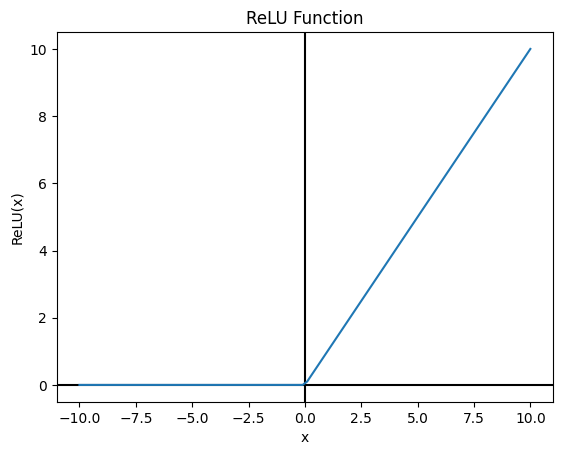

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def relu(x):
    return np.maximum(0, x)

x = np.linspace(-10, 10, 100)  # 生成-10到10之间的100个点
y = relu(x)

fig, ax = plt.subplots()  # 创建一个带有坐标轴的图形

# 绘制坐标轴
ax.axhline(y=0, color='k')  # 水平坐标轴线
ax.axvline(x=0, color='k')  # 垂直坐标轴线

# 绘制ReLU函数
ax.plot(x, y)

ax.set_xlabel('x')  # 设置x轴标签
ax.set_ylabel('ReLU(x)')  # 设置y轴标签
ax.set_title('ReLU Function')  # 设置标题

plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# 构建卷积神经网络模型
model = Sequential()

# 添加卷积层
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))

# 添加另一个卷积层
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# 添加全连接层
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

# 打印网络结构
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 64)                1

### **Test**

In [ ]:
Final=[]
outlist=[]

with open('/content/valid.txt') as f:
  for line in f:
      peak_index=1
      if(line.startswith('Name')):
          cut=line.find('/')
          AminoSequence=line[6:cut]
          #charge state
          charge_state=line[cut+1]
      elif(line.startswith('Comment')):
          Comment=line[9:]
          massleft=int(line.find('Parent'))
          massright=int(line.find('CE',massleft))
          #parent_mass
          parent_mass=line[massleft+7:massright-1]
      elif(line.startswith('Num peaks')):
          Numpeak=int(line[11:])
      else:
          peaklist=line.split("\t",2)
          if(len(peaklist)==3):
              peak_value=peaklist[0]
              peak_intensity=peaklist[1]
              peak_annotation=peaklist[2][1:len(peaklist[2])-2]
              modification=''
              #tmp=np.array([peak_index,peak_value,peak_intensity,parent_mass,charge_state,peak_annotation,modification,AminoSequence])
              tmp=[peak_index,peak_value,peak_intensity,parent_mass,charge_state,peak_annotation,modification,AminoSequence]
              Final.append(tmp)

model = load_model("/content/Conv1d_new_modification.h5")
dual_pos_model=load_model('/content/fully_dual_pos_v9_modification.h5')

outlist=[]
max_peak=0
for index in range(len(Final)):
  tmplist=[]
  tmplist.append(Final[index][1])
  max_peak=max(float(Final[index][1]),max_peak)
  tmplist.append(Final[index][2])
  tmplist.append(Final[index][3])
  tmplist.append(Final[index][4])
  tmplist.append(Final[index][5])
  tmplist.append(Final[index][7])
  tmplist.append(anno_iden_2(Final[index][5]))

  outlist.append(tmplist)
now_peptide=outlist


parent_mass=now_peptide[0][2]
charge_state=now_peptide[0][3]
now_peptide=np.array(now_peptide,dtype=object)
valid_vector=[]
ranklist=[]
togemass=float(parent_mass)*float(charge_state)-float(charge_state)+1.99
for a in range(len(now_peptide)):
  ranklist.append(float(now_peptide[a][1]))

ranklist.sort()
max_mass=float(now_peptide[a][2])*float(now_peptide[a][3])-float(now_peptide[a][3])+1.99
tmp=np.zeros(int((float(max_mass)+2*float(mass_map.get('W')+1))*100))
count=0

for i in range(0,len(now_peptide)):
  if(int(float(now_peptide[i][0])*100)<len(tmp)):
    tmp[int(float(now_peptide[i][0])*100)]=(ranklist.index(float(now_peptide[i][1]))+1)/len(now_peptide)
valid_mass_array=tmp

for i in range(len(now_peptide)):
  spec_vector=window_search_1d(valid_mass_array,now_peptide[i][0],now_peptide[count][2],now_peptide[count][3])
  valid_vector.append(spec_vector)

valid_vector=np.array(valid_vector,dtype=object)
valid_vector = K.cast_to_floatx(valid_vector)

result = model.predict(valid_vector)
final_rank_list=[]
dic={}
mass_dic={}
tmplist=[]
for a in range(len(result)):
  Final[a].append(result[a][0])
  tmplist.append(result[a][0])
  dic[result[a][0]]=outlist[a][4]
  mass_dic[result[a][0]]=outlist[a][0]

tmplist=np.array(tmplist)
tmplist=np.sort(tmplist)

for a in range(len(tmplist)):
  tmp=[]
  val=tmplist[a]
  anno=dic[val]
  mass=mass_dic[val]

  tmp.append(val)
  tmp.append(anno)
  tmp.append(mass)

  final_rank_list.append(tmp)
#yb_result(result,now_peptide,max_mass)
proba_value=calcu_proba_val(max_mass,result,now_peptide)
#dp=calcu_dp(mass_map,proba_value,max_mass)

#permu_list_search=generate_permu_list()
high_threshold=find_max_mass(final_rank_list)
#copy
copy_proba_val=copy_log_proba_val(proba_value)

permutation_list_b=generate_permu_list_b()
permutation_list_y=generate_permu_list_y()


copy_proba_val_check=check_poss(permutation_list_b,permutation_list_y,copy_proba_val)

#!!!!!!!!!!!!!!!!!!!
#===============================================
valid_vector=[]
add_now_peptide=add_charge_peak(high_threshold,max_mass,now_peptide,Final)


max_mass=float(now_peptide[0][2])*float(now_peptide[0][3])-float(now_peptide[0][3])+1.99
tmp=np.zeros(int((float(max_mass)+2*float(mass_map.get('W')+1))*100))
count=0

for i in range(0,len(add_now_peptide)):
  if(int(float(add_now_peptide[i][0])*100)<len(tmp)):
    tmp[int(float(add_now_peptide[i][0])*100)]=(ranklist.index(float(add_now_peptide[i][1]))+1)/len(add_now_peptide)
valid_mass_array=tmp

for i in range(len(add_now_peptide)):
  spec_vector=window_search_1d(valid_mass_array,add_now_peptide[i][0],add_now_peptide[count][2],add_now_peptide[count][3])
  valid_vector.append(spec_vector)

valid_vector=np.array(valid_vector,dtype=object)
valid_vector = K.cast_to_floatx(valid_vector)

add_result = model.predict(valid_vector)
tmp=np.zeros(int((float(max_mass)+2*float(mass_map.get('W')+1))*100))
tmp=tmp.tolist()
for a in range(len(tmp)):
  tmp[a]=[0,a/100]

count=0
for a in range(len(add_result)):
  #rank版本
  this_peak_score=add_result[a][0]
  this_peak_pos=poscacu(float(add_now_peptide[a][0]))
  tmp[this_peak_pos]=[this_peak_score,float(add_now_peptide[a][0])]
final_mass_array=tmp
add_mass_list=[]
for a in add_now_peptide:
  add_mass_list.append(poscacu(float(a[0])))



total_feature_map=np.array(cacu_total_feature_peak_only(final_mass_array,max_mass,togemass,add_now_peptide))
total_feature_map=total_feature_map.reshape(len(total_feature_map)*len(total_feature_map[0]),-1)
#计算dp的原矩阵
peak_pos_20_result=batch_predict_peak_only(total_feature_map,final_mass_array,dual_pos_model,len(add_now_peptide))

#原始正确
#==========================================================================================
dp,dp_copy=dual_pos_dp_cacu_peak_only(peak_pos_20_result,final_mass_array,togemass,add_now_peptide,add_mass_list)
path,pos_path,predict_seq=find_path(dp,final_mass_array,poscacu(max_mass-1))
all_path=find_path_all(dp,final_mass_array,poscacu(max_mass-1))
print("random result:")
print(path)
print("All possible result:")
print(all_path)


80/80 [==============================] - 0s 2ms/step
random result:
['N', 'N', 'Y', 'V', 'D', 'I', 'D', 'M', 'K']
All possible result:
['NNYVDIDMK', 'DIYVDIDMK', 'EVYVDIDMK', 'IDYVDIDMK', 'LDYVDIDMK', 'MPYVDIDMK', 'PMYVDIDMK', 'WAYVDIDMK', 'VEYVDIDMK', 'AWYVDIDMK']


In [ ]:
pos_path

[103650, 92244, 80839, 64533, 51727, 40224, 28820, 17511, 1900]

In [ ]:
print(path)

['N', 'N', 'Y', 'V', 'D', 'I', 'D', 'M', 'K']


In [ ]:
all_path

['NNYVDIDMK',
 'DIYVDIDMK',
 'EVYVDIDMK',
 'IDYVDIDMK',
 'LDYVDIDMK',
 'MPYVDIDMK',
 'PMYVDIDMK',
 'WAYVDIDMK',
 'VEYVDIDMK',
 'AWYVDIDMK']